In [71]:
import pkasolver as ps
from pkasolver import util
from pkasolver import analysis
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import random

#define PairData Class
class PairData(Data):
    def __init__(self, edge_index, x, edge_index2, x2):
        super(PairData, self).__init__()
        self.edge_index = edge_index
        self.x = x
        self.edge_index2 = edge_index2
        self.x2 = x2

    def __inc__(self, key, value):
        if key == 'edge_index':
            return self.x.size(0)
        if key == 'edge_index2':
            return self.x2.size(0)
        else:
            return super().__inc__(key, value)
        
# data = PairData(edge_index_p, x_p, edge_index_d, x_d)
# data_list = [data, data]
# loader = DataLoader(data_list, batch_size=2, follow_batch=['x_p', 'x_d'] )
# batch = next(iter(loader))


def make_nodes(mol):
    x = []
    for atom in mol.GetAtoms():
        x.append(
            np.array(
                [
                    #atom.GetIdx() + num_atoms * i,
                    #float(atom.GetProp("_GasteigerCharge")),
                    atom.GetSymbol() == "C",
                    atom.GetSymbol() == "O",
                    atom.GetSymbol() == "N",
                    atom.GetSymbol() == "P",
                    atom.GetSymbol() == "F",
                    atom.GetSymbol() == "Cl",
                    atom.GetSymbol() == "I",
                    atom.GetFormalCharge(),
                    atom.GetChiralTag(),
                    atom.GetHybridization(),
                    atom.GetNumExplicitHs(),
                    atom.GetIsAromatic(),
                    atom.GetTotalValence(),
                    atom.GetTotalDegree()
                ]
            )
        )
    return torch.tensor(np.array([np.array(xi) for xi in x]), dtype=torch.float)

def make_edges_and_attr(mol):
    edges = []
    edge_attr = []
    for bond in mol.GetBonds():
        edges.append(
            np.array(
                [
                    [bond.GetBeginAtomIdx()],
                    [bond.GetEndAtomIdx()],
                ]
            )
        )
        edge_attr.append(
            [bond.GetBondTypeAsDouble(), bond.GetIsConjugated()]
        )
    edge_index = torch.tensor(np.hstack(np.array(edges)), dtype=torch.long)
    edge_attr = torch.tensor(np.array(edge_attr), dtype=torch.float)
    return edge_index, edge_attr

def Mol_to_PairData(prot, deprot):
    x_p = make_nodes(prot)
    edge_index_p, edge_attr_p = make_edges_and_attr(prot)
    
    x_d = make_nodes(deprot)
    edge_index_d, edge_attr_d = make_edges_and_attr(deprot)
    
    data = PairData(edge_index_p, x_p, edge_index_d, x_d)
    data.edge_attr = edge_attr_p
    data.edge_attr2 = edge_attr_d
    return data.to(device=device)

,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,smiles,protonated,deprotonated,ka
0,6.21,6.09,10,basic,['chembl25'],1702768,Brc1c(NC2CC2)nc(C2CC2)nc1N1CCCCCC1,,,6.165950e-07
1,7.46,8.2,9,basic,['chembl25'],273537,Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1,,,3.467369e-08
2,4.2,3.94,9,basic,['datawarrior'],7175,Brc1cc2cccnc2c2ncccc12,,,6.309573e-05
3,3.73,5.91,8,acidic,['datawarrior'],998,Brc1ccc(-c2nn[n-]n2)cc1,,,1.862087e-04
4,11.0,8.94,13,basic,['chembl25'],560562,Brc1ccc(Br)c(N(CC2CC2)C2=[NH+]CCN2)c1,,,1.000000e-11

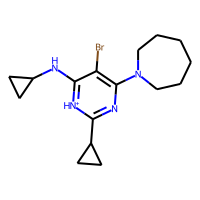
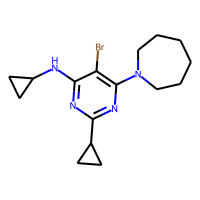
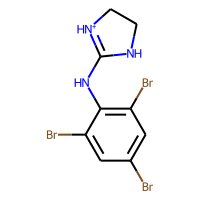
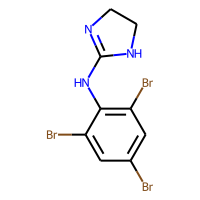
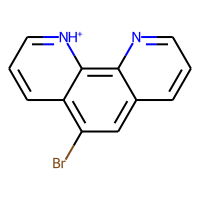
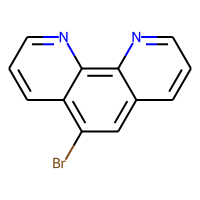
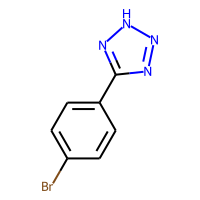
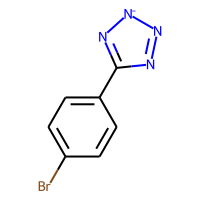
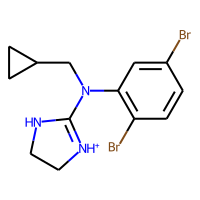
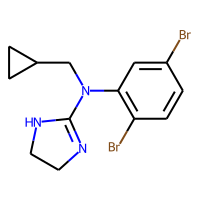

In [38]:
data_folder_Bal = "../data/Baltruschat/"
SDFfile1 = data_folder_Bal + "combined_training_datasets_unique.sdf"
SDFfile2 = data_folder_Bal + "novartis_cleaned_mono_unique_notraindata.sdf"
SDFfile3 = data_folder_Bal + "AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf"
# specify device
device = 'cpu'
#device = 'cuda'


df1 = ps.util.import_sdf(SDFfile1)
df2 = ps.util.import_sdf(SDFfile2)
df3 = ps.util.import_sdf(SDFfile3)

#Data corrections:
df1.marvin_atom[90] = "3"

df1 = util.conjugates_to_DataFrame(df1)
df1 = util.sort_conjugates(df1)
df1 = util.pka_to_ka(df1)
df1.head()

In [73]:
#create pyG Dataset

dataset = []
for i in range(len(df1.index)):
    dataset.append(Mol_to_PairData(df1.protonated[i],df1.deprotonated[i]))
    dataset[i].y = torch.tensor([float(df1.pKa[i])], dtype=torch.float32, device=device)

print(dataset[0], '\n\n' ,dataset[0].x,'\n\n', dataset[0].edge_index)

#split train and test set

random.shuffle(dataset)

split_length=int(len(dataset)*train_test_split)
train_dataset = dataset[:split_length]
test_dataset = dataset[split_length:]
#create Dataloader objects that contain batches 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, follow_batch=['x', 'x2'])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, follow_batch=['x', 'x2'])

PairData(edge_attr=[24, 2], edge_attr2=[24, 2], edge_index=[2, 24], edge_index2=[2, 24], x=[21, 14], x2=[21, 14], y=[1]) 

 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 3., 3.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 4.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 4., 3.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 4., 3.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 4., 3.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 3., 1., 1., 4., 3.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1., 4., 3.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 1., 3., 2.],
        [1., 0., 0

In [98]:
batch = next(iter(train_loader))
print(batch)
dataset[0].num_features
#dataset[0].num_edge_features
len(test_loader)

Batch(batch=[1096], edge_attr=[1164, 2], edge_attr2=[1164, 2], edge_index=[2, 1164], edge_index2=[2, 1164], x=[1096, 14], x2=[1096, 14], x2_batch=[1096], x_batch=[1096], y=[64])


19

In [77]:
#set Hyperparameters
train_test_split = 0.8
hidden_channels = 64
learning_rate = 0.001
batch_size = 64
num_epochs = 10000



In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import GCNConv
from torch_geometric.nn import NNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import global_add_pool
from torch import optim

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1)
        
        num_features = dataset[0].num_features
        num_edge_features = dataset[0].num_edge_features
        
        
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, dataset[0].num_node_features* 96))
        self.conv1 = NNConv(dataset[0].num_node_features, 96, nn=nn)
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, 96* hidden_channels))
        self.conv2 = NNConv(96, hidden_channels, nn=nn)
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, hidden_channels* hidden_channels))
        self.conv3 = NNConv(hidden_channels, hidden_channels, nn=nn)
        self.conv4 = NNConv(hidden_channels, hidden_channels, nn=nn)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch, edge_attr):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_attr)
        x = x.relu()
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        x = x.relu() + 0.000001
        
        return x

model_p = GCN(hidden_channels=hidden_channels).to(device=device)
model_d = GCN(hidden_channels=hidden_channels).to(device=device)
print(model_p, model_d)

optimizer1 = torch.optim.Adam(model_p.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(model_d.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
criterion_v = torch.nn.L1Loss() # that's the MAE Loss
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, patience=5, verbose=True)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, patience=5, verbose=True)

In [ ]:
def train(loader):
    model_p.train()
    model_d.train()
    for data in loader:  # Iterate in batches over the training dataset. 
        prot_out = model_p(data.x, data.edge_index, data.x_batch,  data.edge_attr)  # Perform a single forward pass.
        #print(data.x, data.edge_index, data.x_batch,  data.edge_attr) 
        deprot_out = model_d(data.x2, data.edge_index2, data.x2_batch,  data.edge_attr2)
        #out = prot_out 
        out = torch.log10(torch.div(deprot_out, prot_out))
        #print('prot_out',out)
        loss = criterion(out.flatten(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer1.step()  # Update parameters based on gradients.
        optimizer2.step()
        optimizer1.zero_grad() # Clear gradients.
        optimizer2.zero_grad()
        
def test(loader):
    model_p.eval()
    model_d.eval()
    loss = torch.Tensor([0]).to(device=device)
    for data in loader:  # Iterate in batches over the training dataset.
        prot_out = model_p(data.x, data.edge_index, data.x_batch,  data.edge_attr)  # Perform a single forward pass.
        deprot_out = model_d(data.x2, data.edge_index2, data.x2_batch,  data.edge_attr2)
        #out = prot_out 
        out = torch.log10(torch.div(deprot_out, prot_out))
        loss += criterion_v(out.flatten(), data.y)
    return loss/len(loader) # MAE loss of batches can be summed and divided by the number of batches
     
for epoch in range(1, num_epochs+1):
    train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 1 == 0:
        print(f'Epoch: {epoch:03d}, Train MAE: {train_acc.item():.4f}, Test MAE: {test_acc.item():.4f}')

Epoch: 001, Train MAE: 1.8578, Test MAE: 1.8942
Epoch: 002, Train MAE: 1.8464, Test MAE: 1.8768
Epoch: 003, Train MAE: 1.9164, Test MAE: 1.9423
Epoch: 004, Train MAE: 1.8572, Test MAE: 1.8783
Epoch: 005, Train MAE: 1.8225, Test MAE: 1.8430
Epoch: 006, Train MAE: 1.8163, Test MAE: 1.8398
Epoch: 007, Train MAE: 1.9443, Test MAE: 1.9816
Epoch: 008, Train MAE: 1.8954, Test MAE: 1.9302
Epoch: 009, Train MAE: 1.8025, Test MAE: 1.8427
Epoch: 010, Train MAE: 1.8890, Test MAE: 1.9181
Epoch: 011, Train MAE: 1.8231, Test MAE: 1.8421
Epoch: 012, Train MAE: 1.7981, Test MAE: 1.8164
Epoch: 013, Train MAE: 1.7672, Test MAE: 1.7745
Epoch: 014, Train MAE: 1.7449, Test MAE: 1.7555
Epoch: 015, Train MAE: 1.7172, Test MAE: 1.7238
Epoch: 016, Train MAE: 1.8840, Test MAE: 1.9055
Epoch: 017, Train MAE: 1.8370, Test MAE: 1.8549
Epoch: 018, Train MAE: 1.7581, Test MAE: 1.7807
Epoch: 019, Train MAE: 1.7742, Test MAE: 1.7676
Epoch: 020, Train MAE: 1.7199, Test MAE: 1.7020
Epoch: 021, Train MAE: 1.7305, Test MAE: